# Few-Shot Learning via Prototypical Network

We run the whole file before last submit, therefore the detail number of result might different from the report.

## Generate Images with Patterns

In [1]:
import os
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ====== 基本設定 ======
IMG_SIZE = 64          # 影像大小 64x64
N_CLASSES = 10
SPLITS = {
    "train": 150,      # 每類 150 張
    "val": 20,         # 每類 20 張
    "test": 30,        # 每類 30 張
}
OUT_ROOT = "dataset"   # 輸出的資料夾

np.random.seed(42)     


# ====== 建座標網格 (x,y in [-1,1]) ======
xs = np.linspace(-1, 1, IMG_SIZE)
ys = np.linspace(-1, 1, IMG_SIZE)
X, Y = np.meshgrid(xs, ys)  # shape (H, W)


# ====== 各類 pattern 生成函數 ======
def gen_stripes_horizontal():
    """class 0: 水平條紋"""
    omega = np.random.uniform(6, 14)          # 頻率
    phi   = np.random.uniform(0, 2 * np.pi)   # 相位
    pattern = np.sin(omega * Y + phi)
    img = (pattern > 0).astype(np.float32)    # 二值化 0/1
    return img


def gen_stripes_diagonal():
    """class 1: 斜線條紋"""
    theta = np.deg2rad(np.random.uniform(30, 60))  # 旋轉角度
    Xr = X * np.cos(theta) - Y * np.sin(theta)
    Yr = X * np.sin(theta) + Y * np.cos(theta)
    omega = np.random.uniform(6, 14)
    phi   = np.random.uniform(0, 2 * np.pi)
    pattern = np.sin(omega * Yr + phi)
    img = (pattern > 0).astype(np.float32)
    return img


def gen_dots():
    """class 2: 點陣"""
    img = np.zeros_like(X, dtype=np.float32)
    # 隨機格距 & 半徑
    d = np.random.uniform(0.25, 0.40)  # 格子間距 (在 [-1,1] 座標下)
    r = np.random.uniform(0.05, 0.10)  # 半徑
    jitter = 0.05                      # 格點抖動

    xs_centers = np.arange(-1 + d, 1, d)
    ys_centers = np.arange(-1 + d, 1, d)
    for cx in xs_centers:
        for cy in ys_centers:
            cx_j = cx + np.random.uniform(-jitter, jitter)
            cy_j = cy + np.random.uniform(-jitter, jitter)
            mask = (X - cx_j) ** 2 + (Y - cy_j) ** 2 <= r ** 2
            img[mask] = 1.0
    return img


def gen_checker():
    """class 3: 棋盤格"""
    img = np.zeros_like(X, dtype=np.float32)
    # 隨機 cell 大小 (以 pixel 為單位)
    cell_min, cell_max = 4, 12
    cell_size = np.random.randint(cell_min, cell_max + 1)

    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            cell_x = i // cell_size
            cell_y = j // cell_size
            if (cell_x + cell_y) % 2 == 0:
                img[i, j] = 1.0
            else:
                img[i, j] = 0.0
    return img


def gen_concentric():
    """class 4: 同心圓"""
    # 中心稍微偏移
    cx = np.random.uniform(-0.2, 0.2)
    cy = np.random.uniform(-0.2, 0.2)
    R = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    # ring 寬度
    dr = np.random.uniform(0.10, 0.20)
    rings = np.floor(R / dr).astype(int)
    img = (rings % 2 == 0).astype(np.float32)
    return img


def gen_waves():
    """class 5: 波浪紋 (多條 sine wave)"""
    img = np.zeros_like(X, dtype=np.float32)
    num_waves = np.random.randint(2, 5)  # 幾條波
    for _ in range(num_waves):
        omega = np.random.uniform(4, 10)
        phi   = np.random.uniform(0, 2 * np.pi)
        amp   = np.random.uniform(0.2, 0.5)
        thickness = np.random.uniform(0.05, 0.12)
        # 中心線: y = amp * sin(omega * x + phi)
        center_y = amp * np.sin(omega * X + phi)
        mask = np.abs(Y - center_y) < thickness
        img[mask] = 1.0
    return img

def gen_spiral():
    """class 6: spiral pattern"""
    # 極座標轉換
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)

    # 螺距、頻率
    k = np.random.uniform(4, 7)
    a = np.random.uniform(0.5, 1.0)

    pattern = np.sin(k * Theta + a * R * 6.0)
    img = (pattern > 0).astype(np.float32)
    return img

def gen_radial():
    """class 7: radial lines from center"""
    Theta = np.arctan2(Y, X)

    # 放射線數量 n_rays
    n_rays = np.random.randint(8, 16)
    pattern = np.sin(n_rays * Theta)
    img = (pattern > 0).astype(np.float32)
    return img

def gen_fragments():
    """class 8: broken fragment pattern"""
    img = np.zeros_like(X, dtype=np.float32)

    # 隨機產生不規則區塊
    num_patches = np.random.randint(5, 12)

    for _ in range(num_patches):
        cx = np.random.uniform(-0.8, 0.8)
        cy = np.random.uniform(-0.8, 0.8)
        sx = np.random.uniform(0.1, 0.4)
        sy = np.random.uniform(0.1, 0.4)
        angle = np.random.uniform(0, np.pi)

        # 不規則旋轉橢圓
        Xr = (X - cx) * np.cos(angle) - (Y - cy) * np.sin(angle)
        Yr = (X - cx) * np.sin(angle) + (Y - cy) * np.cos(angle)
        mask = (Xr / sx)**2 + (Yr / sy)**2 <= 1

        img[mask] = 1.0

    return img

def gen_noise():
    """class 9: noise texture"""
    freq = np.random.uniform(8, 16)
    noise = np.sin(freq * X) + np.cos(freq * Y)
    noise += 0.3 * np.random.normal(0, 1, X.shape)
    img = (noise > 0).astype(np.float32)
    return img




GEN_FUNCS = {
    0: gen_stripes_horizontal,
    1: gen_stripes_diagonal,
    2: gen_dots,
    3: gen_checker,
    4: gen_concentric,
    5: gen_waves,
    6: gen_spiral,
    7: gen_radial,
    8: gen_fragments,
    9: gen_noise,
}

CLASS_NAMES = {
    0: "class_0_stripes",
    1: "class_1_diag_stripes",
    2: "class_2_dots",
    3: "class_3_checker",
    4: "class_4_circles",
    5: "class_5_waves",
    6: "class_6_spiral",
    7: "class_7_radial",
    8: "class_8_fragments",
    9: "class_9_noise",
}

In [2]:
# ====== 簡單增強 ======
def augment(img):
    """
    img: float32, in [0,1], shape (H,W)
    回傳：float32, in [0,1]
    """
    # 隨機左右翻轉
    if np.random.rand() < 0.5:
        img = np.fliplr(img)
    # 隨機上下翻轉
    if np.random.rand() < 0.5:
        img = np.flipud(img)
    # brightness & contrast
    alpha = np.random.uniform(0.8, 1.2)  # 對比
    beta = np.random.uniform(-0.1, 0.1)  # 亮度偏移
    img = alpha * img + beta
    # 加一點高斯噪聲
    noise = np.random.normal(0, 0.05, size=img.shape)
    img = img + noise
    img = np.clip(img, 0.0, 1.0)
    return img


# ====== 生成並儲存 ======
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def generate_and_save_split(split_name, n_per_class):
    print(f"Generating split: {split_name} ({n_per_class} images per class)")
    for cls_id in range(N_CLASSES):
        cls_name = CLASS_NAMES[cls_id]
        out_dir = os.path.join(OUT_ROOT, split_name, cls_name)
        ensure_dir(out_dir)

        gen_fn = GEN_FUNCS[cls_id]
        for idx in range(n_per_class):
            img = gen_fn()           # (H,W), float32 0/1
            img = augment(img)       # 增強
            img_uint8 = (img * 255).astype(np.uint8)

            # 轉成 PIL Image 並存成 PNG
            pil_img = Image.fromarray(img_uint8, mode="L")
            filename = f"img_{idx:04d}.png"
            pil_img.save(os.path.join(out_dir, filename))

        print(f"  Class {cls_id} ({cls_name}): done.")

print("Generating dataset...")
for split, n_imgs in SPLITS.items():
    generate_and_save_split(split, n_imgs)
print("Done!")

Generating dataset...
Generating split: train (150 images per class)
  Class 0 (class_0_stripes): done.
  Class 1 (class_1_diag_stripes): done.
  Class 2 (class_2_dots): done.


/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_18239/1833933200.py:44: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img_uint8, mode="L")


  Class 3 (class_3_checker): done.
  Class 4 (class_4_circles): done.
  Class 5 (class_5_waves): done.
  Class 6 (class_6_spiral): done.
  Class 7 (class_7_radial): done.
  Class 8 (class_8_fragments): done.
  Class 9 (class_9_noise): done.
Generating split: val (20 images per class)
  Class 0 (class_0_stripes): done.
  Class 1 (class_1_diag_stripes): done.
  Class 2 (class_2_dots): done.
  Class 3 (class_3_checker): done.
  Class 4 (class_4_circles): done.
  Class 5 (class_5_waves): done.
  Class 6 (class_6_spiral): done.
  Class 7 (class_7_radial): done.
  Class 8 (class_8_fragments): done.
  Class 9 (class_9_noise): done.
Generating split: test (30 images per class)
  Class 0 (class_0_stripes): done.
  Class 1 (class_1_diag_stripes): done.
  Class 2 (class_2_dots): done.
  Class 3 (class_3_checker): done.
  Class 4 (class_4_circles): done.
  Class 5 (class_5_waves): done.
  Class 6 (class_6_spiral): done.
  Class 7 (class_7_radial): done.
  Class 8 (class_8_fragments): done.
  Class

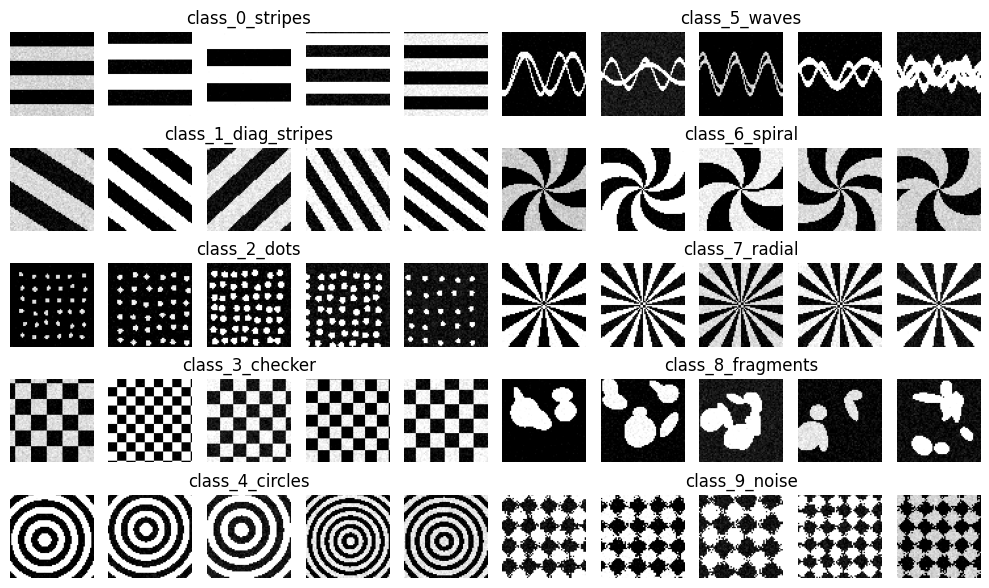

In [3]:
ROOT = "dataset/train"
N_SHOW = 5

# 取得類別清單（你原本有 class_names[1:]，我繼續沿用）
class_names = sorted(os.listdir(ROOT))
class_names = class_names[1:]       # 保持你的原設定，若無需求可刪掉此行

# 分成左右兩欄
left_classes = class_names[:5]      # 前 5 類
right_classes = class_names[5:10]   # 後 5 類

fig, axes = plt.subplots(
    nrows=5, ncols=10,  # 每列：空白 1 + 左欄 7 + 空白 1 + 右欄 7 = 16欄，但視覺簡化用14欄
    figsize=(10, 6)
)

# 為避免 axes shape 不一致，統一 flatten
axes = axes.reshape(5, 10)

def plot_column(classes, start_col):
    """
    classes: 欲顯示的類別名稱（最多 5 個）
    start_col: 此欄開始的 col index
    """
    for row, cls in enumerate(classes):
        folder = os.path.join(ROOT, cls)
        files = sorted(os.listdir(folder))[:N_SHOW]
        for i, fname in enumerate(files):
            ax = axes[row, start_col + i]   # 每一列放入該類第 i 張
            img = Image.open(os.path.join(folder, fname))
            ax.imshow(img, cmap="gray")
            ax.axis("off")

            # 在中間貼上標題（第 4 張上方）
            if i == 2:
                ax.set_title(cls, fontsize=12)

# 左欄從 col=0 開始
plot_column(left_classes, start_col=0)

# 右欄從 col=7 開始（保留中間一欄白色區隔用）
plot_column(right_classes, start_col=5)

plt.tight_layout()
plt.show()

## Prototypical Network

### Config

這裡我們試作 3-way 1-shot 與 3-way 3-shot，query 都各取 8 張。

訓練時跑 ```META_TRAIN_EPISODES``` 次 episodes，而測試時取 ```META_TEST_EPISODES``` 次 episodes 的準確率的平均。

In [4]:
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

DATA_ROOT = "./dataset/train"
N_WAY = 3
SHOTS_TRAIN = 1
QUERIES = 8
META_TRAIN_EPISODES = 2000
META_TEST_EPISODES  = 300
EMBED_DIM = 64
LR = 1e-3

### Class Index

把資料集轉成 {0:[0, 1, 2, ..., 149], 1:[150, 151, ..., 299], ...} 哪個類別裡有哪些圖片

In [6]:
class ImageFolderIndexed(datasets.ImageFolder):
    pass

def build_class_index(dataset, selected_classes):
    cls_to_idx = {}
    for cls in selected_classes:
        cls_to_idx[cls] = []
    for i, (_, label) in enumerate(dataset.samples):
        if label in cls_to_idx:
            cls_to_idx[label].append(i)
    return cls_to_idx

### Enbedding Function $f_\theta$ (Conv4)

In [7]:
class Conv4(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(1,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,64,3,padding=1),nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,64,3,padding=1),nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,64,3,padding=1),nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Linear(64*4*4, EMBED_DIM)

    def forward(self, x):
        h = self.body(x)
        h = h.view(h.size(0), -1)
        return self.fc(h)


### Evaluation

In [8]:
# 抽 episode
def sample_episode(cls_to_indices, n_way, k, q):
    classes = random.sample(list(cls_to_indices.keys()), n_way)
    support, query, sl, ql = [], [], [], []
    for epi_label, c in enumerate(classes):
        items = random.sample(cls_to_indices[c], k+q)
        support += items[:k]
        query   += items[k:]
        sl += [epi_label]*k
        ql += [epi_label]*q
    return support, torch.tensor(sl), query, torch.tensor(ql)

# 根據 index 抽對應的影像出來
def load_batch(dataset, ids):
    xs=[]
    for i in ids:
        x,_ = dataset[i]
        xs.append(x)
    return torch.stack(xs)

# 計算 loss
def prototypical_loss(z, labels, n_way, k, q):
    N = n_way*(k+q)
    support = z[:n_way*k]
    query   = z[n_way*k:]
    sup_lab = labels[:n_way*k]
    qry_lab = labels[n_way*k:]

    protos=[] # 計算各原型中心
    for c in range(n_way):
        protos.append(support[sup_lab==c].mean(0))
    protos = torch.stack(protos)

    q_expand = query.unsqueeze(1)
    p_expand = protos.unsqueeze(0)
    dists = ((q_expand - p_expand)**2).sum(2) # 算 L2 距離
    logits = -dists
    loss = F.cross_entropy(logits, qry_lab)
    acc  = (logits.argmax(1) == qry_lab).float().mean().item()
    return loss, acc


### Meta-Train & Test

In [9]:
def meta_train(model, opt, dataset, cls_map):
    loss_history = []
    acc_history = []
    for ep in range(1, META_TRAIN_EPISODES+1):
        s, sl, q, ql = sample_episode(cls_map, N_WAY, SHOTS_TRAIN, QUERIES)
        all_ids = s + q
        all_labels = torch.cat([sl, ql]).to(DEVICE)
        x = load_batch(dataset, all_ids).to(DEVICE)
        z = model(x)
        loss, acc = prototypical_loss(z, all_labels, N_WAY, SHOTS_TRAIN, QUERIES)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_history.append(loss.item())
        acc_history.append(acc)
        if ep % 100 == 0:
            print(
                f"[Train] Episode {ep}/{META_TRAIN_EPISODES} "
                f"Loss: {loss.item():.8f} Acc: {acc*100:.4f}%"
            )

    plt.figure(figsize=(12, 4))

    # 左：Loss 曲線
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, linestyle='-', label="Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.legend()

    # 右：Accuracy 曲線
    plt.subplot(1, 2, 2)
    plt.plot(acc_history, linestyle='-', label="Accuracy", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Curve")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

@torch.no_grad()
def meta_test(model, dataset, cls_map, shots):
    accs=[]
    for _ in range(META_TEST_EPISODES):
        s, sl, q, ql = sample_episode(cls_map, N_WAY, shots, QUERIES)
        x = load_batch(dataset, s+q).to(DEVICE)
        y = torch.cat([sl, ql]).to(DEVICE)
        z = model(x)
        _, acc = prototypical_loss(z, y, N_WAY, shots, QUERIES)
        accs.append(acc)
    return sum(accs)/len(accs)


### Main

META TRAIN EPISODES = 2000, META TEST EPISODES = 300
Start meta-training...
[Train] Episode 100/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 200/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 300/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 400/2000 Loss: 0.00000009 Acc: 100.0000%
[Train] Episode 500/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 600/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 700/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 800/2000 Loss: 0.00011516 Acc: 100.0000%
[Train] Episode 900/2000 Loss: 6.41554213 Acc: 83.3333%
[Train] Episode 1000/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 1100/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 1200/2000 Loss: 1.38367081 Acc: 95.8333%
[Train] Episode 1300/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 1400/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 1500/2000 Loss: 0.00000000 Acc: 100.0000%
[Train] Episode 1600/2000 Loss: 0.00000000 Acc: 100.0000%
[Train]

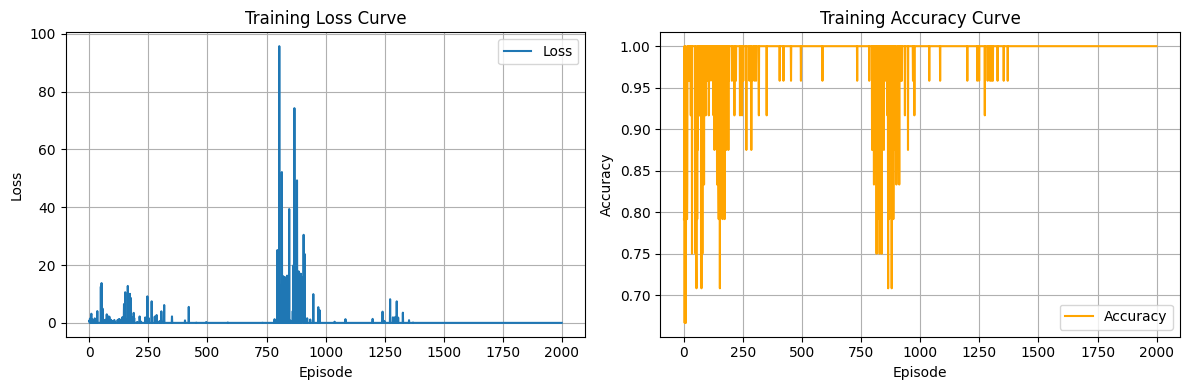

Testing 3-way 1-shot
Acc: 0.9259722195068996
Testing 3-way 3-shot
Acc: 0.9666666632890701


In [10]:
# 轉灰階
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# 讀資料
dataset = ImageFolderIndexed(DATA_ROOT, transform=transform)

# 定義訓練及測試類別
# META_TRAIN = sorted(np.random.choice(
#     list(range(N_CLASSES)), size=7, replace=False
# ).tolist())
# print("META_TRAIN classes:", META_TRAIN)
META_TRAIN = [0,1,2,3,4,5,6]
# META_TEST  = sorted(list(set(range(N_CLASSES)) - set(META_TRAIN)))
# print("META_TEST classes:", META_TEST)
META_TEST  = [7,8,9]

# 建立 class -> index 關係
train_map = build_class_index(dataset, META_TRAIN)
test_map  = build_class_index(dataset, META_TEST)

# 建立模型及優化器
model = Conv4().to(DEVICE) # 就是 f_\theta ，使資料能 embedding
opt = torch.optim.Adam(model.parameters(), lr=LR)

# 開始訓練
print(f"META TRAIN EPISODES = {META_TRAIN_EPISODES}, META TEST EPISODES = {META_TEST_EPISODES}")
print("Start meta-training...")
meta_train(model, opt, dataset, train_map)

# 測試分3類，每類只給一張或三張
print("Testing 3-way 1-shot")
acc1 = meta_test(model, dataset, test_map, shots=1)
print("Acc:", acc1)

print("Testing 3-way 3-shot")
acc3 = meta_test(model, dataset, test_map, shots=3)
print("Acc:", acc3)


### Test

Built global prototypes for classes: ['class_0_stripes', 'class_1_diag_stripes', 'class_2_dots', 'class_3_checker', 'class_4_circles', 'class_5_waves', 'class_6_spiral', 'class_7_radial', 'class_8_fragments', 'class_9_noise']


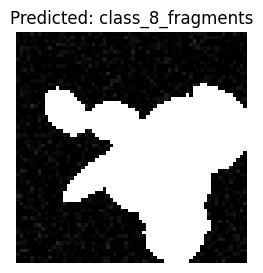

Predicted class: class_8_fragments
Probabilities:
  class_0_stripes      : 0.000
  class_1_diag_stripes : 0.000
  class_2_dots         : 0.000
  class_3_checker      : 0.000
  class_4_circles      : 0.000
  class_5_waves        : 0.000
  class_6_spiral       : 0.000
  class_7_radial       : 0.000
  class_8_fragments    : 1.000
  class_9_noise        : 0.000


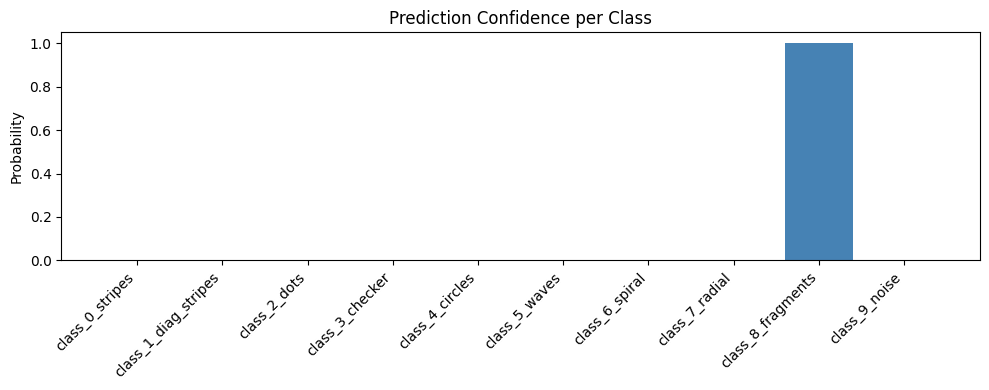

In [11]:
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# ======================================
# Step 1: 為每一個全域類別建立 prototype
# ======================================

def build_global_prototypes(dataset, model, device=DEVICE, max_per_class=50):
    """
    為每一個 global 類別 c 建立一個 prototype:
        c_c = 平均(該類部分訓練影像的 embedding)
    max_per_class: 每個類別最多用多少張影像來平均
    """
    model.eval()
    num_classes = len(dataset.classes)
    
    # 先為每個類別挑一些 index（避免全部都用，太慢）
    cls_to_indices = {c: [] for c in range(num_classes)}
    for idx, (_, label) in enumerate(dataset.samples):
        if len(cls_to_indices[label]) < max_per_class:
            cls_to_indices[label].append(idx)
    
    protos = []
    with torch.no_grad():
        for c in range(num_classes):
            idxs = cls_to_indices[c]
            # 安全檢查：類別裡至少要有一張圖
            if len(idxs) == 0:
                raise ValueError(f"Class {c} ({dataset.classes[c]}) has no samples!")
            
            xs = [dataset[i][0] for i in idxs]          # 只取影像 tensor
            x_batch = torch.stack(xs, dim=0).to(device) # (n_c, C, H, W)
            z = model(x_batch)                          # (n_c, D)
            proto = z.mean(dim=0)                       # (D,)
            protos.append(proto)
    
    protos = torch.stack(protos, dim=0).to(device)      # (num_classes, D)
    return protos

# 建立 10 類的 global prototypes（只需跑一次）
global_prototypes = build_global_prototypes(dataset, model, DEVICE, max_per_class=50)
class_names = dataset.classes
print("Built global prototypes for classes:", class_names)

# ======================================
# Step 2: 單張圖片分類函式
# ======================================

def predict_single_image_with_plot(
    img_path, model, prototypes, class_names, device=DEVICE, show_image=True
):
    model.eval()

    # 讀取影像
    img_pil = Image.open(img_path).convert("L")
    x = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        z = model(x)  # (1, D)

        # prototypes: (C, D)
        z_exp = z.unsqueeze(1)  # (1, 1, D)
        p_exp = prototypes.unsqueeze(0)  # (1, C, D)
        dists = ((z_exp - p_exp) ** 2).sum(dim=2)  # (1, C)
        logits = -dists
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred_idx = probs.argmax()

    # 顯示影像與預測
    if show_image:
        plt.figure(figsize=(3, 3))
        plt.imshow(img_pil, cmap="gray")
        plt.title(f"Predicted: {class_names[pred_idx]}")
        plt.axis("off")
        plt.show()

    print(f"Predicted class: {class_names[pred_idx]}")
    print("Probabilities:")
    for i, name in enumerate(class_names):
        print(f"  {name:20s} : {probs[i]:.3f}")

    # ====== 新增：直方圖 / bar chart ======
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(len(class_names)), probs, color="steelblue")
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
    plt.ylabel("Probability")
    plt.title("Prediction Confidence per Class")
    plt.tight_layout()
    plt.show()

    return pred_idx, probs


# ======================================
# Step 3: 給一張圖，實際跑看看
# ======================================

img_path = "dataset/train/class_8_fragments/img_0087.png"  # 隨便換圖片
pred_idx, probs = predict_single_image_with_plot(
    img_path,
    model,
    global_prototypes,
    dataset.classes,
    device=DEVICE,
    show_image=True,
)


### PCA

In [12]:
from sklearn.decomposition import PCA

def plot_pca_embeddings(model, dataset, transform, device, 
                        max_points=None, figsize=(7,7)):
    """
    Compute and visualize PCA embeddings of a dataset using a trained model.
    
    Args:
        model: trained encoder (e.g., Conv4)
        dataset: dataset returning (PIL_image, label)
        transform: preprocessing transform used in training/testing
        device: "cpu" or "cuda"
        max_points: int or None. If set, randomly subsample this many points.
        figsize: figure size for the scatter plot.
    
    Returns:
        emb2d: PCA-reduced 2D embeddings (N x 2)
        labels: numpy array of labels (N,)
    """
    model.eval()

    all_embeds = []
    all_labels = []

    # ----- Step 1: Extract all embeddings -----
    with torch.no_grad():
        for img, label in dataset:
            x = transform(img).unsqueeze(0).to(device)
            z = model(x)
            all_embeds.append(z.cpu().numpy())
            all_labels.append(label)

    all_embeds = np.vstack(all_embeds)   # shape (N, D)
    all_labels = np.array(all_labels)    # shape (N,)

    # ----- Optional subsampling (useful if dataset is large) -----
    if max_points is not None and max_points < len(all_embeds):
        idx = np.random.choice(len(all_embeds), max_points, replace=False)
        embeds_sub = all_embeds[idx]
        labels_sub = all_labels[idx]
    else:
        embeds_sub = all_embeds
        labels_sub = all_labels

    # ----- Step 2: PCA to 2D -----
    pca = PCA(n_components=2)
    emb2d = pca.fit_transform(embeds_sub)

    # ----- Step 3: Plot -----
    plt.figure(figsize=figsize)
    for cls in np.unique(labels_sub):
        mask = (labels_sub == cls)
        plt.scatter(
            emb2d[mask, 0], 
            emb2d[mask, 1], 
            s=15, 
            label=f"class {cls}",
            alpha=0.7
        )

    plt.legend()
    plt.title("PCA Visualization of Embeddings")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()

    return emb2d, labels_sub


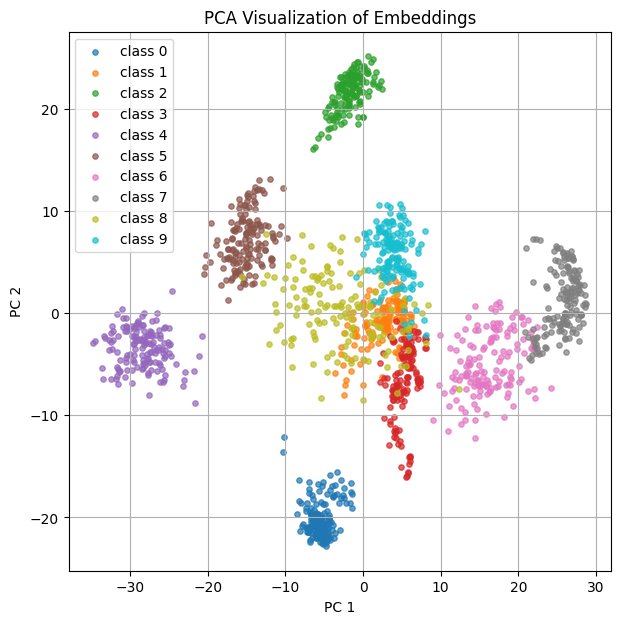

In [13]:
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder("dataset/train", transform=None)

emb2d, labels = plot_pca_embeddings(
    model,
    full_dataset,
    transform,
    DEVICE,
    max_points=2000   # 若資料多可抽2000點
)